In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from topological_memory_clustering import *

import time
import pickle

In [21]:
def align(data, len_max_in=50):
    if len_max_in <=0:
        for i in range(len(data)):
            len_max = max(len_max, len(data[i]))
    else:
        len_max = len_max_in
    ret = np.zeros([len(data), len_max, len(data[0][0])])
    for i in range(len(data)):
        for j in range(len(data[i][0])):
            ret[i,:,j] = np.interp(np.linspace(0, 1, len_max), np.linspace(0, 1, len(data[i])), np.array(data[i])[:,j])
    return ret

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = y.copy()
    for i in range(y.shape[1]):
        y_smooth[:,i] = np.convolve(y[:,i], box, mode='same')
    return y_smooth

def load_data(file_name, space=1, traj=100, steps=50):
    # demos = np.load(file_name, allow_pickle=True, encoding='bytes')[()]
    demos = pickle.load(open('pole_imesh_reaching_full_200.p', 'rb'), encoding='bytes')
    # x = align(demos[0][0:traj])[:,:,:] # Joint space
    x = align(demos[space][0:traj], steps)[:,:,:] # iMesh space
    # Diff to get dx
    dx = x.copy()
    for i in range(len(x)):
        dx[i] = smooth(np.diff(x[i], axis=0, append=x[i][-1:]), min(20, steps))
    xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(x, dx)]
    t = np.linspace(0, 100, x[0].shape[0])
    return (np.array(x), np.array(dx), np.array(xdx), t)

def compute(demos, data, scale = 1.0):
    # Compute the sparse filtration
    tic = time.time()

    # Dense
    result, D = homology.compute_homology_filtration(demos, debug=True)

    toc = time.time()
    timesparse = toc-tic
    print("Elapsed Time: %.3g seconds, %i Edges added"%(timesparse, result['num_edges']))
    return (result, D, )

In [22]:
(demos_x, demos_dx, demos_xdx, t) = load_data('shlef_imesh_reaching_full_200.npy', 1, 50, 10)
demos = demos_xdx[:,:,:]
print(demos_x.shape, demos_dx.shape, demos_xdx.shape)
data = np.vstack([d for d in demos])
result_iMesh, D = compute(demos, data)

(50, 10, 39) (50, 10, 39) (50, 10, 78)
Distance computation time: 0.03443336486816406
Trajectory distance modification time: 2.8371810913085938e-05
[Dense] Elapsed Time: 2.15 seconds, 88124 Edges added
Elapsed Time: 2.19 seconds, 88124 Edges added


In [23]:
(demos_x, demos_dx, demos_xdx, t) = load_data('shlef_imesh_reaching_full_200.npy', 0, 50, 10)
demos = demos_xdx[:,:,:]
data = np.vstack([d for d in demos])
result_joint, D = compute(demos, data, 1.0)

Distance computation time: 0.027876853942871094
Trajectory distance modification time: 2.6464462280273438e-05
[Dense] Elapsed Time: 4.76 seconds, 88136 Edges added
Elapsed Time: 4.79 seconds, 88136 Edges added


In [24]:
# pickle.dump(result_iMesh, open('pole_imesh_reaching_full_200_results.p', 'wb'))
# pickle.dump(result_joint, open('pole_joint_reaching_full_200_results.p', 'wb'))

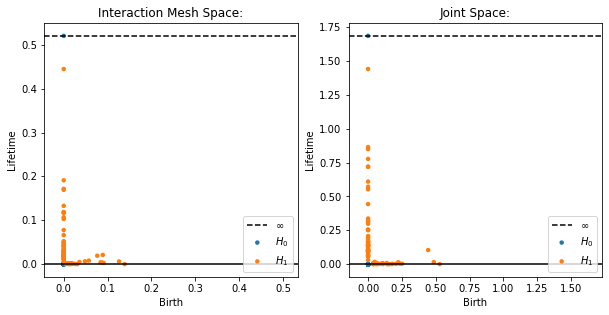

In [25]:
%matplotlib inline

# And plot the persistence diagrams on top of each other
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title("Interaction Mesh Space:")
plot_diagrams(result_iMesh['dgms'], show=False, lifetime=True)

plt.subplot(122)
plt.title("Joint Space:")
plot_diagrams(result_joint['dgms'], show=False, lifetime=True)

plt.show()

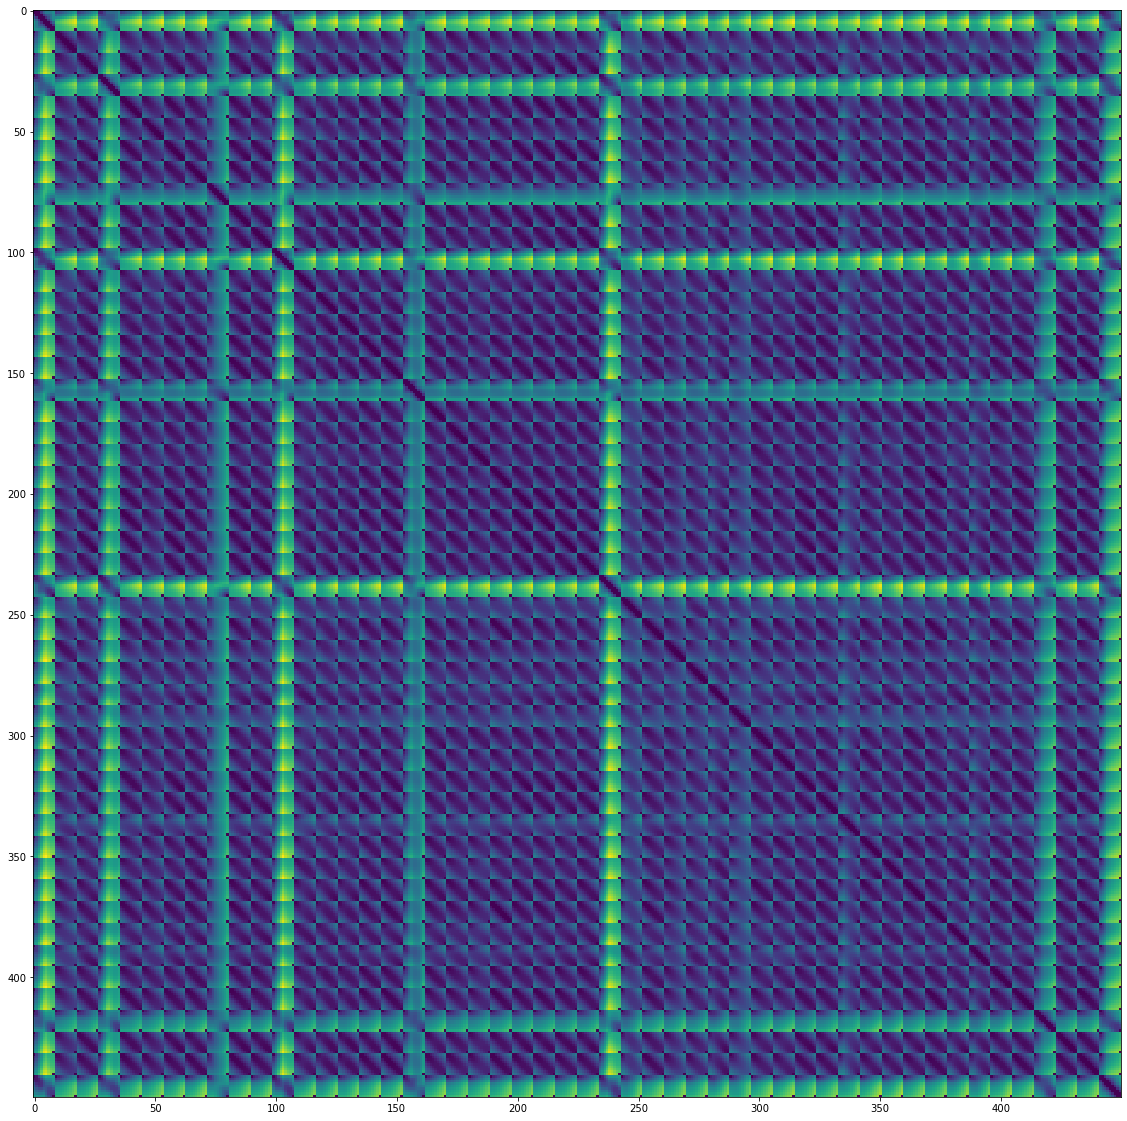

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(D)